# Combine_PS1_SDSS_ZTF

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
from astropy.table import unique
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

The SDSS-PS1 clean combined light curves (only SDSS r-band and PS1 DR2 r-band, no offsets) live in 
`../dp2/real_sdss_ps1r_dr2_cleaned/`.  

In [16]:
lcDir = '../dp2/real_sdss_ps1r_dr2_cleaned/'
lcnames = np.array(os.listdir(lcDir))

dbIDs = np.array([int(x[:-4]) for x in lcnames])

lcnames_good = lcnames[np.in1d(dbIDs,ztf['dbID'].data)]

lcname = lcnames_good[0]
print(lcname)
lc = Table.read(lcDir+lcname, format='ascii')

908716.txt


In [17]:
lc[:4]

mjd,mag,magerr,survey
float64,float64,float64,str4
51081.350927,18.849,0.011,sdss
51819.422031,18.458,0.009,sdss
52225.246715,18.708,0.01,sdss
52288.081134,18.713,0.01,sdss


In [2]:
# read in the ZTF light curves...
ztf = Table.read('../raw_data/ztf_dr1_s82_qso_lcs.tbl', format='ipac')

In [5]:
ztf['matchid']

10396413002408
10396403002622
10396373002538
10397412002458
10398412003126
10398332018091
10399371010360
10400321005459
10401411006611
10401411001276
10401362002563


In [70]:
fid = np.array(ztf[m]['filterid'].data[0][1:-1].split(',')).astype(int)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

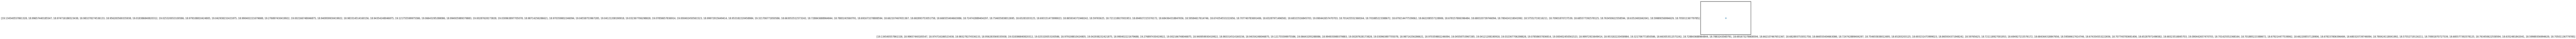

In [23]:
%matplotlib inline
m = ztf['dbID'] == int(lcname[:-4])


In [58]:
mjd = np.array(ztf[m]['mjd'].data[0][1:-1].split(','), dtype=float)
mag = np.array(ztf[m]['mag'].data[0][1:-1].split(','), dtype=float)
magerr = np.array(ztf[m]['magerr'].data[0][1:-1].split(','), dtype=float)
psfmag = np.array(ztf[m]['psfmag'].data[0][1:-1].split(','), dtype=float)

<ErrorbarContainer object of 3 artists>

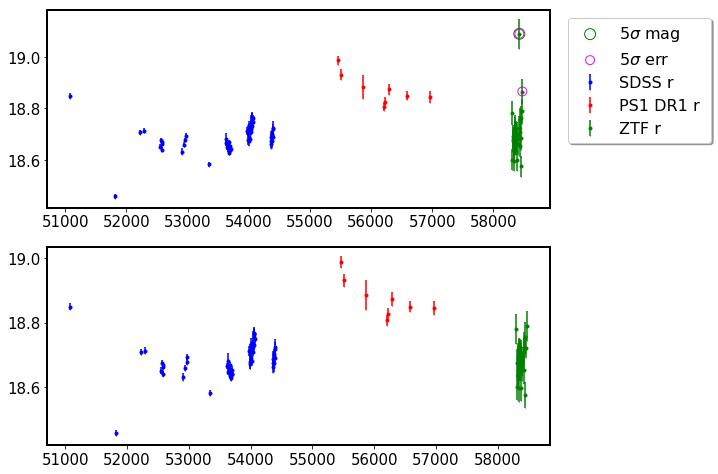

In [83]:
# Illustrate SDSS r , PS1 r  , and ZTF r.   
fig,ax = plt.subplots(2,1,figsize=(9,8))
#lc = Table.read(midDir+lcname, format='ascii')

use_segments = 'sdss,ps1'
colors = ['blue','red']
labels = ['SDSS r', 'PS1 DR1 r ']
j = 0
for s in use_segments.split(','):
    rows = lc['survey'] == s
    # plot the "observed" lc 
    ax[0].errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                fmt=".", capsize=0.2, label=labels[j],
                c = colors[j])
    j += 1 


# add ZTF data 

m = ztf['dbID'] == int(lcname[:-4])
mjd = np.array(ztf[m]['mjd'].data[0][1:-1].split(','), dtype=float)
mag = np.array(ztf[m]['mag'].data[0][1:-1].split(','), dtype=float)
magerr = np.array(ztf[m]['magerr'].data[0][1:-1].split(','), dtype=float)
fid = np.array(ztf[m]['filterid'].data[0][1:-1].split(',')).astype(int)

lc1 = Table([mjd,mag,magerr,fid], names=['mjd', 'mag', 'magerr', 'fid'])

if np.sum(fid == 2) > 0 :
    rows = fid == 2 
    lc1r = lc1[rows].copy() # select only r-band rows as LC 
    ax[0].errorbar(lc1r['mjd'].data, 
                   lc1r['mag'].data,
                   lc1r['magerr'].data, 
                   fmt=".", capsize=0.2, label='ZTF r',
                c = 'green')
    
    
# flag the 5 sigma ZTF points , that would be removed 

Nsig = 5 
#rows = lc['survey'] == 'ps1' 
x = lc1r['mag'].data
sigmaGmag =  0.7413 * (np.percentile(x,75) -\
                    np.percentile(x,25))
msig = np.abs(np.ma.median(x) - x) > Nsig *sigmaGmag

ax[0].scatter(lc1r['mjd'][msig],x[msig],
           s=120, facecolors='none', edgecolors='g', 
              label=str(Nsig)+r'$\sigma$ mag')

# also, flag the SDSS or PS1 points that have an error over 5 times that 
# of the sigmaG of the errors for the entire  light curve ...
# SDSS and PS1 points are similar enough to be considered together
# - remove points with way larger error than the rest 
x  = lc1r['magerr'].data
sigmaGerr =  0.7413 * (np.percentile(x,75) -\
                     np.percentile(x,25))
merr = np.abs(np.ma.median(x) - x)   > Nsig *  sigmaGerr

ax[0].scatter(lc1r['mjd'][merr], lc1r['mag'][merr],
           s=80, facecolors='none', edgecolors='magenta', 
              label=str(Nsig)+r'$\sigma$ err')
## remove the 5 sigma outliers  in mag and error space 
lc1r.remove_rows(msig | merr)            
            
# add legend 
ax[0].legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.02,1),
        ncol=1, fancybox=True, shadow=True, )#, loc='upper right')



# do the day-averaging for ZTF points 
# find out which days have more than 1 obs 
lc1r['mjdint'] = lc1r['mjd'].astype(int)
lc1r['Nobs']  = 1
lc1r['medmag'] = lc1r['mag']
lc1r['avgmag'] = lc1r['mag'] # same with avgmag ...  
lc1r['avgerr'] = lc1r['magerr'] 
value, count = np.unique(lc1r['mjdint'], return_counts=True)

# for those that do, update the value of Nobs, 
# and populate the medmag with the median of these days 
for mjd in value[count > 1] : 
    rows = lc1r['mjdint'] == mjd
    lc1r['Nobs'][rows] = count[value == mjd]
    lc1r['medmag'][rows] = np.ma.median(lc1r['mag'][rows])

    weights = 1.0 / (lc1r['magerr'][rows] * lc1r['magerr'][rows])
    average = np.sum(weights * lc1r['mag'][rows]) / np.sum(weights)

    lc1r['avgmag'][rows] = average
    avgerr  = 1.0 / (np.sqrt(np.sum(weights)))
    # if error < 0.02 , we add 0.01 in quadrature ... 
    if avgerr < 0.02 : 
        avgerr  = np.sqrt(avgerr**2 + 0.01**2)
    lc1r['avgerr'][rows] = avgerr

# finally, keep only one of the multiples
lc2 = unique(lc1r, keys='mjdint')


# second panel : 
# plot the day-averaged ZTF, cleaned by removing 5 sigma outliers... 
use_segments = 'sdss,ps1'
colors = ['blue','red']
labels = ['SDSS r', 'PS1 DR1 r ']
j = 0
for s in use_segments.split(','):
    rows = lc['survey'] == s
    # plot the "observed" lc 
    ax[1].errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                fmt=".", capsize=0.2, label=labels[j],
                c = colors[j])
    j += 1 
    
ax[1].errorbar(lc2['mjd'].data, 
               lc2['avgmag'].data,
               lc2['avgerr'].data,  
                fmt=".", capsize=0.2, label='ZTF r',
                c = 'green')

In [80]:
lc1r['mjdint'] = lc1r['mjd'].astype(int)

In [81]:
# Illustrate SDSS,  CRTS 

mjd,mag,magerr,fid,mjdint
float64,float64,float64,int64,int64
58397.4019907,18.663053512573242,0.04301848262548447,2,58397
58354.4378009,18.728843688964844,0.045029617846012115,2,58354
58472.1226968,18.7883243560791,0.04694131761789322,2,58472
58321.4830671,18.691673278808594,0.043880268931388855,2,58321
58357.4638079,18.662107467651367,0.04299035668373108,2,58357
58324.4831481,18.682893753051758,0.04361376911401749,2,58324
58342.4780671,18.666555404663086,0.043122876435518265,2,58342
58422.3353241,18.724742889404297,0.044901128858327866,2,58422
58437.26875,18.754655838012695,0.04584813117980957,2,58437
